In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy 
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import distance_matrix 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score

In [38]:
df=pd.read_csv("1632560262896716.csv")
df.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [39]:
df.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

# **Exploring data**

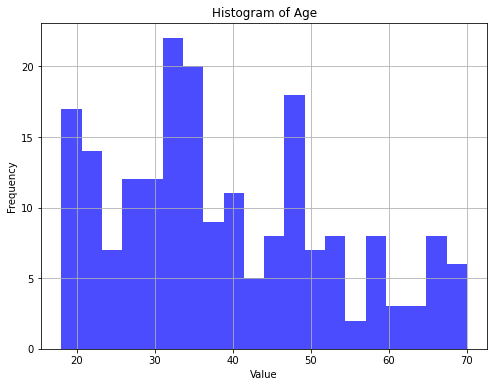

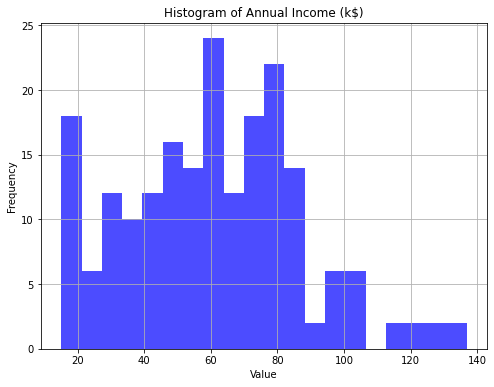

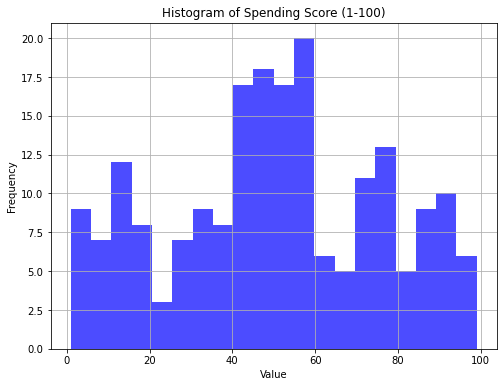

In [40]:
selected_columns = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)'] 

for column in selected_columns:
    plt.figure(figsize=(8, 6)) 
    plt.hist(df[column], bins=20, color='blue', alpha=0.7)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.grid(True)
    
    plt.show()

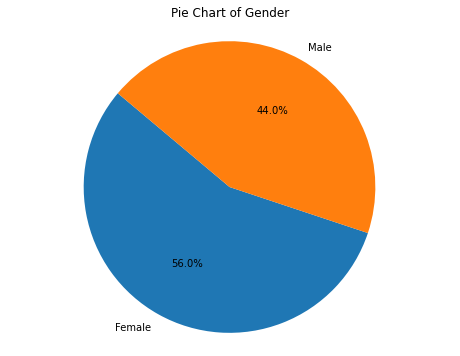

In [49]:
selected_columns = ['Gender']
for column in selected_columns:
    plt.figure(figsize=(8, 6))
    value_counts = df[column].value_counts()
    
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  
    plt.title(f'Pie Chart of {column}')
    
    # Show the pie chart
    plt.show()


Now we want to explore correlations between features of the dataset.

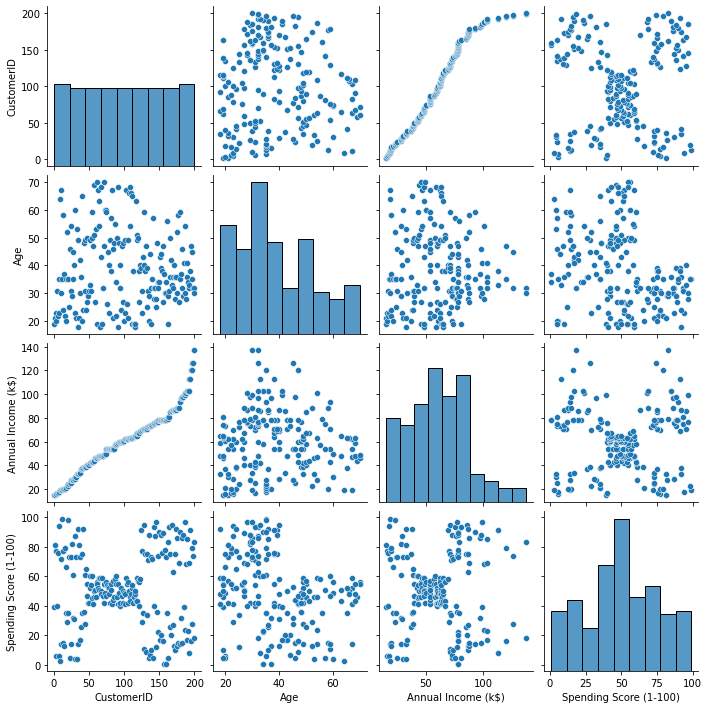

In [41]:
sns.pairplot(df)
plt.show()


Annual income and spending-score plot seems to have five distinct clusters. So, these two features are chosen to be shown in scatter plots of the model trainings.
Customer-id and annual income seems to have a high correlation.

In [42]:
df.corr()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,1.000000,-0.026763,0.977548,0.013835
Age,-0.026763,1.000000,-0.012398,-0.327227
Annual Income (k$),0.977548,-0.012398,1.000000,0.009903
Spending Score (1-100),0.013835,-0.327227,0.009903,1.000000


Now we want to show this correlations on a heat-map matrix 

<Figure size 576x432 with 0 Axes>

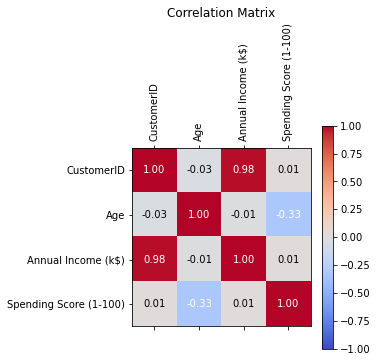

In [43]:
correlation_matrix = df.corr()

plt.figure(figsize=(8, 6))
cax = plt.matshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(cax)

plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Correlation Matrix')

for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        text = "{:.2f}".format(correlation_matrix.iloc[i, j])
        plt.text(j, i, text, ha='center', va='center', color='k' if -0.3 <= correlation_matrix.iloc[i, j] <= 0.3 else 'w')

plt.show()

# **K Means

First we just plot income and spending-score

In [44]:
df_k = df.drop(['CustomerID', 'Gender', 'Age'], axis=1)
scaler = StandardScaler()
df_k_scaled = scaler.fit_transform(df_k)
df_k.head()


,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


Finding the optimal value for k using elbow method

C:\Users\hajis\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


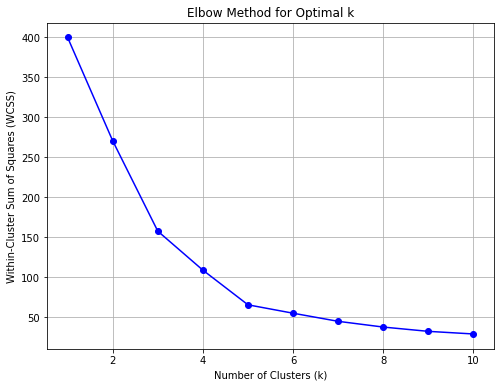

In [45]:
k_values = range(1, 11)
wcss_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_k_scaled)
    wcss_values.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss_values, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)


plt.show()

k = 5 was chosen based on the elbow method.

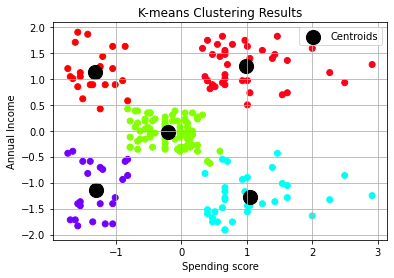

In [47]:
k = 5 
kmeans = KMeans(n_clusters=k)
kmeans.fit(df_k_scaled)

plt.scatter(df_k_scaled[:, 0], df_k_scaled[:, 1], c=kmeans.labels_, cmap = 'hsv')

cluster_centers_ = kmeans.cluster_centers_


plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='k', label='Centroids')


plt.xlabel('Spending score')
plt.ylabel('Annual Income')
plt.title('K-means Clustering Results')
plt.legend()
plt.grid(True)
plt.show()




Now we we include age and Gender as well as income and spending score.

First we have to convert gender into numeric values

In [48]:
gender_mapping = {
    'Male': 1,
    'Female': 2
}

df['Gender'] = df['Gender'].map(gender_mapping)
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,1,19,15,39
1,2,1,21,15,81
2,3,2,20,16,6
3,4,2,23,16,77
4,5,2,31,17,40


In [49]:
df_k_2 = df.drop(['CustomerID'], axis=1).values
df_k_2_scaled = scaler.fit_transform(df_k_2)


C:\Users\hajis\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


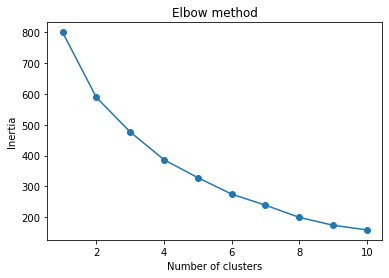

In [50]:
inertias2 = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_k_2_scaled)
    inertias2.append(kmeans.inertia_)

plt.plot(range(1,11), inertias2, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Now we choose k=7

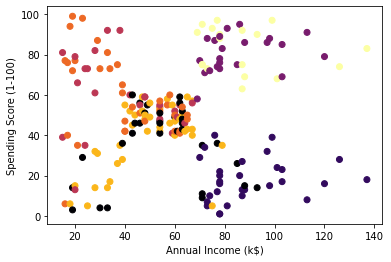

In [51]:
kmeans2 = KMeans(n_clusters=7)
kmeans2.fit(df_k_2_scaled)

plt.scatter(df_k_2[:, 2], df_k_2[:, 3], c=kmeans2.labels_, cmap = 'inferno')
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.show()

It seems that including all features is not a good idea. Then, we add the cluster number of first clustering to the dataset:

In [52]:
df['Cluster-k'] = kmeans.fit_predict(df_k_scaled)
df.head(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster-k
0,1,1,19,15,39,5
1,2,1,21,15,81,3
2,3,2,20,16,6,4
3,4,2,23,16,77,3
4,5,2,31,17,40,5
5,6,2,22,17,76,3
6,7,2,35,18,6,4
7,8,2,23,18,94,3
8,9,1,64,19,3,4
9,10,2,30,19,72,3


# **Agglomerative Clustering

In [54]:
from sklearn.preprocessing import MinMaxScaler
df_agg = df.drop(['CustomerID', 'Gender', 'Age', 'Cluster-k'], axis=1)
x = df_agg.values 
min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(x)
feature_mtx [0:5]

array([[0.        , 0.3877551 ],
       [0.        , 0.81632653],
       [0.00819672, 0.05102041],
       [0.00819672, 0.7755102 ],
       [0.01639344, 0.39795918]])

In [55]:
def agglom_clustering(features_data, num_clusters, metric, linkage_method = 'average'):
    cluster_model = AgglomerativeClustering(n_clusters=num_clusters,
                                            affinity=metric,
                                            linkage= linkage_method)
 
    clusters = cluster_model.fit_predict(features_data)
    
    return clusters

We now defined a function. Now we use the function with both euclidean and manhattan affinity metric for clustering.

In [56]:
y_euclidean= agglom_clustering(df_agg, 5, 'euclidean')
y_manhattan = agglom_clustering(df_agg, 5, 'manhattan')

In [57]:
def plot_clusters(data, y, metric):
    plt.scatter(data[y==0, 0], data[y==0, 1],
                s=100, c='red',
                label ='Cluster 1')
    plt.scatter(data[y==1, 0], data[y==1, 1],
                s=100, c='blue',
                label ='Cluster 2')
    plt.scatter(data[y==2, 0], data[y==2, 1],
                s=100, c='green',
                label ='Cluster 3')
    plt.scatter(data[y==3, 0], data[y==3, 1],
                s=100, c='purple',
                label ='Cluster 4')
    plt.scatter(data[y==4, 0], data[y==4, 1],
                s=100, c='orange',
                label ='Cluster 5')
    
    plt.title(f'Customers Clustering (using {metric} distance metric)')
    plt.xlabel('Annual Income(k$)')
    plt.ylabel('Spending Score(1-100)')
 
    plt.legend()
    plt.show()

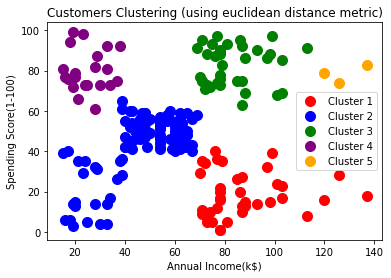

In [58]:
plot_clusters(x, y_euclidean, 'euclidean')

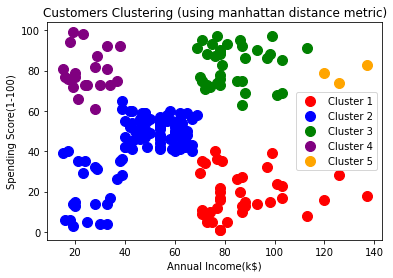

In [59]:
plot_clusters(x, y_euclidean, 'manhattan')

For visulizing dendogram, we need to find the distance matrix and then making linkage using hierarchy class.

In [62]:
from sklearn.metrics.pairwise import euclidean_distances
dist_matrix = euclidean_distances(feature_mtx,feature_mtx) 
print(dist_matrix)

[[0.         0.42857143 0.33683444 ... 0.97742145 1.0227015  1.09616727]
 [0.42857143 0.         0.76535002 ... 0.91263558 1.18880836 1.00020822]
 [0.33683444 0.76535002 0.         ... 1.13772561 0.99933353 1.26531446]
 ...
 [0.97742145 0.91263558 1.13772561 ... 0.         0.57849818 0.12869934]
 [1.0227015  1.18880836 0.99933353 ... 0.57849818 0.         0.66326531]
 [1.09616727 1.00020822 1.26531446 ... 0.12869934 0.66326531 0.        ]]


In [63]:
Z = hierarchy.linkage(dist_matrix, 'complete')


C:\Users\hajis\AppData\Local\Temp\ipykernel_10668\2263504671.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(dist_matrix, 'complete')


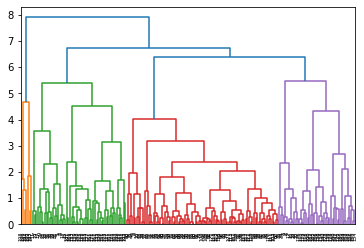

In [64]:
dendro = dendrogram(Z)


In [65]:
df['Cluster-Agg'] = y_euclidean
df.head(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster-k,Cluster-Agg
0,1,1,19,15,39,5,1
1,2,1,21,15,81,3,3
2,3,2,20,16,6,4,1
3,4,2,23,16,77,3,3
4,5,2,31,17,40,5,1
5,6,2,22,17,76,3,3
6,7,2,35,18,6,4,1
7,8,2,23,18,94,3,3
8,9,1,64,19,3,4,1
9,10,2,30,19,72,3,3


# **Density Based Clustering


In [66]:
df_db = df.drop(['CustomerID', 'Cluster-k', 'Age', 'Cluster-Agg', 'Gender'], axis=1)


x_db = df_db.values 
min_max_scaler = MinMaxScaler()
x_db_scaled = StandardScaler().fit_transform(x_db)

db = DBSCAN(eps=0.36, min_samples=4).fit(x_db_scaled)
db.labels_




array([ 2,  0,  1,  0,  2,  0,  1, -1,  1,  0,  1, -1,  1,  0,  1,  0,  2,
        0,  2, -1,  2,  0,  1,  0,  1,  0,  2,  0,  2,  0,  1,  0,  1,  0,
        1,  0,  1,  0,  3,  0,  3, -1,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  4,  3,  4,  3,  4,  5,  4,  5,  4,  3,  4,  5,  4,
        5,  4,  5,  4,  5,  4,  3,  4,  5,  4,  3,  4,  5,  4,  5,  4,  5,
        4,  5,  4,  5,  4,  5,  4,  3,  4,  5,  4,  5,  4,  5,  4,  5,  4,
        5,  4,  5,  4,  5,  4,  5,  4,  5,  4,  6,  4,  5,  4, -1,  4,  6,
       -1,  6,  4,  6, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=int64)

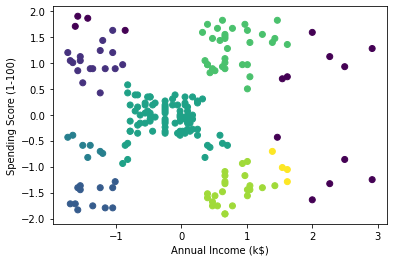

In [68]:
plt.scatter(x_db_scaled [:, 0], x_db_scaled [:, 1], c= db.labels_, cmap = 'viridis')
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.show()

In [70]:
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  
print(f" Number of clusters is : {n_clusters_}")

 Number of clusters is : 7


C:\Users\hajis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Cluster')

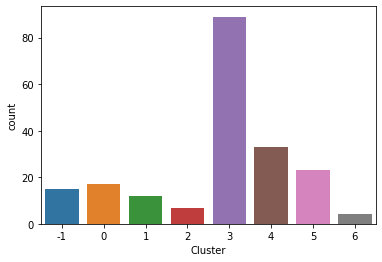

In [71]:
sns.countplot(db.labels_)
plt.xlabel("Cluster")


Now, we add the cluster number of DBSCAN clustering and make the final dataset including clusters of all methods in diffrent columns:

In [72]:
df['Cluster-db'] = labels
df.head(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster-k,Cluster-Agg,Cluster-db
0,1,1,19,15,39,5,1,2
1,2,1,21,15,81,3,3,0
2,3,2,20,16,6,4,1,1
3,4,2,23,16,77,3,3,0
4,5,2,31,17,40,5,1,2
5,6,2,22,17,76,3,3,0
6,7,2,35,18,6,4,1,1
7,8,2,23,18,94,3,3,-1
8,9,1,64,19,3,4,1,1
9,10,2,30,19,72,3,3,0
